### Requirements for file input

1. all of the fits data needs to be in the directory "hsc_images"
2. each object must be under a directory with the object number as the title of the directory. 
    - for example if the object's number is "78" then all of the corresponding files (ie the "redadd..." files" should be under that directory. 
2. There needs to be fits files that have
    - the image data
    - the signififcance data
    - the mask data
    - the world coordinate system info

### Output
1. .fits files of cropped image data and significant data
2. images of the ellipses surrounding the objects in image
3. graph plotting the length of the major axis vs. the ratio of the minor to major axis. Upper left corner represents the sources that are considered point sources. 
4. fits table catalog of all objects in the img_data

These files are what we need to feed to tractor. 

-Dane

In [1]:
import numpy as np
import os
import os.path

# Set up matplotlib and use a nicer set of plot parameters
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse

import sep
import pylab

from astropy.io import fits
from astropy.wcs import WCS

%matplotlib inline

In [2]:
def get_data (path):
    img_data = fits.open(path+'img.fits')[0].data[400:800,400:800]
    sig_data = fits.open(path+'sig.fits')[0].data[400:800,400:800]
    msk_data = fits.open(path+'bad.fits')[0].data[400:800,400:800]
    psf_data = fits.open(path+'psf.fits')[0].data[400:800,400:800]
    
    #create cropped fits file to feed into tractor
    img = fits.PrimaryHDU(img_data)
    img.writeto('img_data_crop_'+num+'.fits')
    
    sig = fits.PrimaryHDU(sig_data)
    sig.writeto('sig_data_crop_'+num+'.fits')
    
    psf = fits.PrimaryHDU(psf_data)
    psf.writeto('psf_data_crop_'+num+'.fits')
    
    return img_data,sig_data,msk_data

img and sig data saved for 126
elliptical image saved for 126
img and sig data saved for 153
elliptical image saved for 153
img and sig data saved for 180
elliptical image saved for 180
img and sig data saved for 207
elliptical image saved for 207
img and sig data saved for 26
elliptical image saved for 26
img and sig data saved for 260
elliptical image saved for 260
img and sig data saved for 314
elliptical image saved for 314
img and sig data saved for 34
elliptical image saved for 34
img and sig data saved for 42
elliptical image saved for 42
img and sig data saved for 529
elliptical image saved for 529
img and sig data saved for 840
elliptical image saved for 840


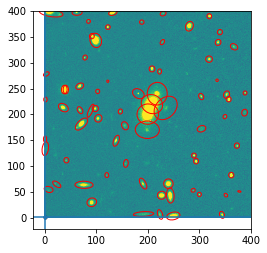

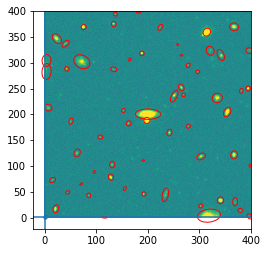

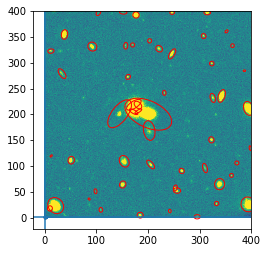

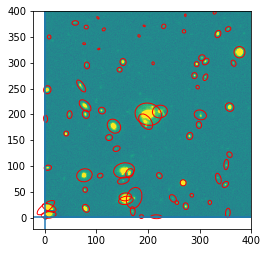

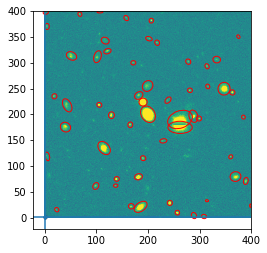

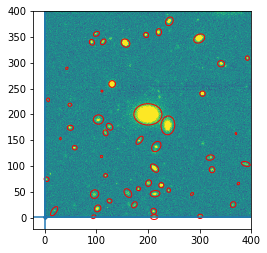

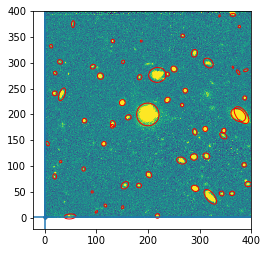

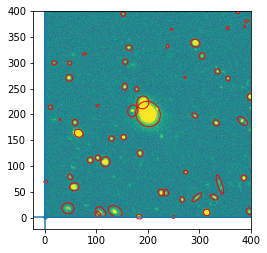

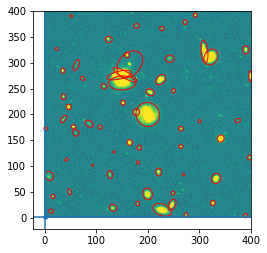

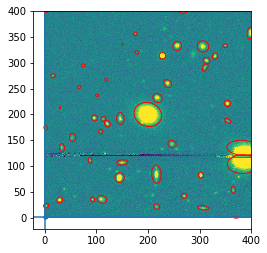

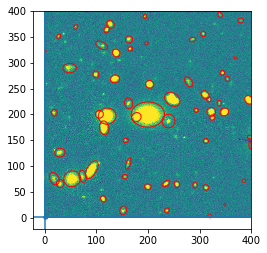

In [3]:
import os
import shutil

directories = os.listdir('hsc_images')
nums = []

for directory in directories:
    #ignore any files that may have been added on accident
    if not str.isdigit(directory[0]):
        continue
    
    num = directory
    nums.append(num)
    path = 'hsc_images/'+num+'/redadd_'+num+'_HSC-I_full_'
    
    img_data, sig_data, msk_data = get_data(path)
    
    print('img and sig data saved for ' + num)
    
    # Change the byteorder (translate the bytes)
    img_data = img_data.byteswap().newbyteorder()
    sig_data = sig_data.byteswap().newbyteorder()
    msk_data = msk_data.byteswap().newbyteorder()
    
    #step 2
    bkg_model = sep.Background(img_data, mask=msk_data, bw=32, bh=32, fw=3, fh=3)
    img_sub = img_data - bkg_model.back()
    
    #step 3
    obj_table, seg_data = sep.extract(img_sub, 5.0, err=sig_data, mask=msk_data, 
                                      minarea=5, deblend_nthresh=32, deblend_cont=0.001,
                                      clean=True, segmentation_map=True)
    
    #step 4
    #gets elliptical approximations of the ends of the galaxies, create visualizations
    fig, ax = plt.subplots()
    img_avg, img_std = np.mean(img_sub), np.std(img_sub)

    im = ax.imshow(img_sub, interpolation='nearest',
                   vmin=(img_avg - img_std), vmax=(img_avg + img_std), 
                   origin='lower')

    for i in range(len(obj_table)):
        e = Ellipse(xy=(obj_table['x'][i], 
                        obj_table['y'][i]),
                    width=(6 * obj_table['a'][i]),
                    height=(6 * obj_table['b'][i]),
                    angle=(obj_table['theta'][i] * 180. / np.pi))
        e.set_facecolor('none')
        e.set_edgecolor('red')
        ax.add_artist(e)
    
    #save elliptical image
    pylab.savefig('elliptical_image_'+num,bbox_inches='tight')
    print('elliptical image saved for '+num)
    
    #step 5

    #get world coordinate system from header and scale pixels to WCS
    img_wcs = WCS(path+'img.fits') 
    pixel_scale = np.abs(img_wcs.pixel_scale_matrix[0][0] * 3600.0) 
    
    #get the arcsec length of major/minor axes
    a_arcsec, b_arcsec = (pixel_scale * obj_table['a']), (pixel_scale * obj_table['b']) 
    
    # Plot the size v.s. shape 
    plt.scatter(a_arcsec, (b_arcsec / a_arcsec), s=5)

    #plot the limits 
    plt.axhline(0.9)
    plt.axvline(0.35)

    plt.savefig('point_source_vis_'+num)
    
    #step 6

    from astropy.table import Table

    x = obj_table['x']
    y = obj_table['y']
    x2 = obj_table['x2']
    y2 = obj_table['y2']
    xy = obj_table['xy']
    a = obj_table['a']
    b = obj_table['b']
    theta = obj_table['theta']
    flux = obj_table['flux']

    point_source = [((b_arcsec[i]/ a_arcsec[i] > .9) and (a_arcsec[i]<.35)) for i in range(len(obj_table))]

    t = Table([x,y,x2,y2,xy,a,b,theta,flux,point_source], 
              names=('x', 'y', 'x2','y2','xy','a','b','theta','flux','point_source'), 
              meta={'name': 'object table'})
    
    #step 7
    tbhdu = fits.BinTableHDU.from_columns(
         [fits.Column(name='x', format='D', array=np.array(x)),
          fits.Column(name='y', format='D', array=np.array(y)),
          fits.Column(name='x2', format = 'D', array=np.array(x2)),
          fits.Column(name='y2', format = 'D', array=np.array(y2)),
          fits.Column(name='xy', format = 'D', array=np.array(xy)),
          fits.Column(name='a', format = 'D', array=np.array(a)),
          fits.Column(name='b', format = 'D', array=np.array(b)),
          fits.Column(name='theta', format = 'D', array=np.array(theta)),
          fits.Column(name='flux', format = 'D', array=np.array(flux)),
          fits.Column(name='point_source', format = 'D', array=np.array(point_source))])
    tbhdu.writeto('tractor_'+num+'.fits')
    

In [4]:
#organize files
directory = os.listdir('./')

#sort in terms of length so there is no instance of a substring of a number
#ie if there is a file 178 and 17, the last for loop will hit '178' first, not '17'
nums.sort(key = len) 
nums.reverse()

for n in nums:
    os.makedirs(n+'_tractor_ready')

for file in directory:
    if 'example' in file or 'tractor_prep' in file or 'hsc' in file:
        continue
    for num in nums:
        if num in file:
            src = os.path.abspath(file)
            dst = os.path.abspath(num+'_tractor_ready')
            shutil.move(src,dst)
            break
    